In [1]:
import os
import types
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import log_softmax, nll_loss, softmax

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from src.visualization.toy_example import plot_moons, plot_multiclass, show_density_grid, show_acquisition_grid, plot_performance_curves
from src.data.toy_example import generate_moons, generate_multiclass
from src.methods.acquisition_functions import EPIG, GeneralEPIG
from src.methods.target_input_distribution import MultivariateGaussian

from src.models.utils import GP_sample
from src.methods.toy_example import run_active_learning_loop_toy

import autograd.numpy as np
from autograd import hessian
from autograd.misc import flatten


In [2]:
from hessian import exact_hessian
from backpack import extend, backpack, extensions
from torch.distributions.multivariate_normal import MultivariateNormal
from math import sqrt

class SimpleLLLA(nn.Module):
    def __init__(self, alpha=1., num_classes: int = 2, n_posterior_samples: int = 1000):
        super(SimpleLLLA, self).__init__()
        
        self.feature_extr = nn.Sequential(
            nn.Linear(2, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(), 
            nn.Linear(32, 32), 
            nn.BatchNorm1d(32),
            nn.ReLU(),
        )      
        self.classifier = nn.Linear(32, num_classes, bias=False)
        
        self.alpha                  = alpha
        self.n_posterior_samples    = n_posterior_samples
        self.num_classes            = num_classes
        self.LLLA_fitted            = False

    def forward(self, x: torch.FloatTensor):
        x = self.feature_extr(x)
        return self.classifier(x)

    def predict_MAP_proba(self, x: np.ndarray):
        x       = torch.FloatTensor(x)
        outputs = self.forward(x)
        return softmax(outputs, dim=1).numpy()
    
    def predict_posterior_proba(self, x: np.ndarray, seed: int = 0):
        probs, _   = self.sample(X=x, n_samples=self.n_posterior_samples, seed=seed)
        return probs
    
    def fit_LLLA(self, Xtrain: torch.FloatTensor, ytrain: torch.LongTensor):
        ### PARTS OF CODE DONE BY THESE PERSONS: https://github.com/wiseodd/last_layer_laplace/blob/master/bnn_laplace_multiclass.ipynb  
        self.LLLA_fitted = True

        self.W_last_layer = list(self.parameters())[-1]
        shape_W = self.W_last_layer.shape

        # Use BackPACK to get the Kronecker-factored last-layer covariance
        extend(self.classifier)
        loss_func = extend(nn.CrossEntropyLoss(reduction='sum'))

        loss = loss_func(self(Xtrain), ytrain)
        with backpack(extensions.KFAC()):
            loss.backward()

        # The Kronecker-factored Hessian of the negative log-posterior
        A, B = self.W_last_layer.kfac

        # The weight decay used for training is the Gaussian prior's precision
        prec0 = 5e-4

        # The posterior covariance's Kronecker factors
        self.U = torch.inverse(A + sqrt(prec0)*torch.eye(shape_W[0]))
        self.V = torch.inverse(B + sqrt(prec0)*torch.eye(shape_W[1]))

    def sample(self, X: np.ndarray, n_samples: int = 1000, seed: int = 0):
        ### PARTS OF CODE DONE BY THESE PERSONS: https://github.com/wiseodd/last_layer_laplace/blob/master/bnn_laplace_multiclass.ipynb  
        assert self.LLLA_fitted, "You must explicitly fit the LLLA layer before trying to sample!" 
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        # feed input through first part of network
        with torch.no_grad():
            z = self.feature_extr(torch.FloatTensor(X))
            # MAP prediction
            Wmap = z @ self.W_last_layer.T

            # v is the induced covariance. 
            # See Appendix B.1 of https://arxiv.org/abs/2002.10118 for the detail of the derivation.
            v = torch.diag(z @ self.V @ z.T).reshape(-1, 1, 1) * self.U

            output_dist = MultivariateNormal(Wmap, v)
            posterior_samples     = torch.zeros((self.num_classes, n_samples, len(X)))
            for n in range(n_samples):
                posterior_samples[:, n, :] = softmax(output_dist.rsample(), dim=1).reshape(self.num_classes, -1)
                
        return posterior_samples.mean(axis=1).reshape(-1, self.num_classes), posterior_samples.cpu().numpy()


In [3]:
def train_model(model, optimizer, Xtrain, ytrain, Xtest, ytest, epochs, val_step, seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

    accs    = {'train': {}, 'validation': {}}
    losses  = {'train': {}, 'validation': {}}
    current_best_loss = np.inf

    pbar = tqdm(range(epochs))
    for epoch in pbar:
        model.train()

        # Set grad zero
        optimizer.zero_grad()

        # Get predictions
        outputs         = model(Xtrain)
        log_probs       = log_softmax(outputs, dim=1)

        # Compute loss
        loss    = nll_loss(log_probs, ytrain)
        loss.backward()
        # Optimize
        optimizer.step()

        # Compute accuracy for batch
        _, pred_class   = torch.topk(outputs, k=1)
        train_acc       = torch.mean((pred_class.flatten() == ytrain).float()).cpu()
        train_loss      = loss.item()

        # Store information
        accs['train'][epoch]    = train_acc 
        losses['train'][epoch]  = train_loss
        
        if epoch % val_step == 0:
            model.eval()
            with torch.no_grad():
                # Get predictions
                outputs         = model(Xtest)
                log_probs       = log_softmax(outputs, dim=1)
                
                # Compute loss
                loss    = nll_loss(log_probs, ytest)

                # Compute accuracy for batch
                _, pred_class   = torch.topk(outputs, k=1)
                val_acc         = torch.mean((pred_class.flatten() == ytest).float()).cpu()
                val_loss        = loss.item()

                accs['validation'][epoch]   = val_acc 
                losses['validation'][epoch] = val_loss

            if losses['validation'][epoch] < current_best_loss:
                current_best_loss   = losses['validation'][epoch]
                best_model          = model
                
                torch.save(model.state_dict(), f'../models/MNIST/{model.__class__.__name__}_best.pth')
                # print("Saved new model!")

        pbar.set_description(f"EPOCH {epoch+1}/{epochs}: Train acc. = {accs['train'][epoch]:.4f} \t | Validation acc. = {accs['validation'][epoch]:.4f} \t | Train loss = {losses['train'][epoch]:.4f} \t | Validation loss = {losses['validation'][epoch]:.4f}")

    return model

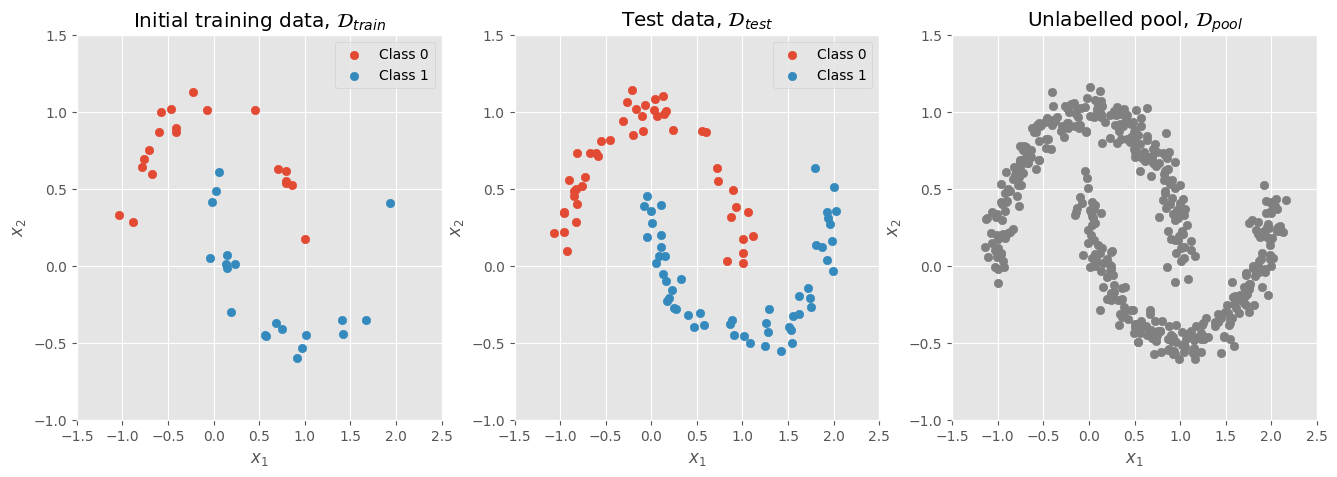

In [4]:
np.random.seed(0)

# Define dataset sizes
N_initial   = 20
N_test      = 100
N_pool      = 500
num_classes = 2

# Generate dataset partitions
Xtrain, ytrain, Xtest, ytest, Xpool, ypool = generate_moons(N_initial_per_class=N_initial, N_test=N_test, N_pool=N_pool)

# Plot the dataset partitions
plot_moons(Xtrain, ytrain, Xtest, ytest, Xpool, ypool)

# Set device
device = torch.device('cpu') #torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

Xtrain  = torch.FloatTensor(Xtrain).to(device)
Xtest   = torch.FloatTensor(Xtest).to(device)
Xpool   = torch.FloatTensor(Xpool).to(device)

ytrain  = torch.LongTensor(ytrain).to(device)
ytest   = torch.LongTensor(ytest).to(device)
ypool   = torch.LongTensor(ypool).to(device)

In [5]:
# Define parameters
lr          = 1e-4
epochs      = 1000
val_step    = 1
seed        = 0

In [6]:
# Set device for model
model = SimpleLLLA(alpha=1., n_posterior_samples=5000)
model.to(device)

optimizer   = optim.Adam(model.parameters(), lr=lr)

train_model(model, optimizer, Xtrain, ytrain, Xtest, ytest, epochs, val_step, seed)

# "train" LLLA 
model.fit_LLLA(Xtrain, ytrain)

EPOCH 10/1000: Train acc. = 0.8000 	 | Validation acc. = 0.7400 	 | Train loss = 0.5454 	 | Validation loss = 0.6316:   0%|          | 0/1000 [00:00<?, ?it/s]

EPOCH 1000/1000: Train acc. = 1.0000 	 | Validation acc. = 0.9600 	 | Train loss = 0.0469 	 | Validation loss = 0.1150: 100%|██████████| 1000/1000 [00:05<00:00, 184.08it/s]


In [7]:
# posterior_samples = model.sample(Xpool, n_samples=5000)
# # plt.hist(posterior_samples[0, :, 0])
# # print(posterior_samples.shape)

# # with torch.no_grad():
# #     print(np.round(model.predict_MAP_proba(Xtrain), 2))
# #     print(np.round(model.predict_posterior_proba(Xtrain), 2))

In [8]:
from src.methods.acquisition_functions import Entropy_temp, BALD_temp, EPIG, GeneralEPIG

In [13]:
def plot_example(acq_fun, next_query):
    
    ### PLOT DECISION BOUNDARY AND ACQUISITION FUNCTION ###
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)

    # Plot model uncertainty across grid
    axs[0] = show_density_grid(model, Xtrain, Xtest, ytrain, ytest, ax=axs[0], fig=fig)
    axs[0].legend()

    # Plot acquisition function across a grid
    axs[1] = show_acquisition_grid(model, acq_fun, Xtrain, ytrain, Xpool, P=150, ax=axs[1], fig=fig)
    axs[1].scatter(next_query[0], next_query[1], color='orange', marker=(5, 1), s=100, label='New query')
    axs[1].legend()

    plt.show()

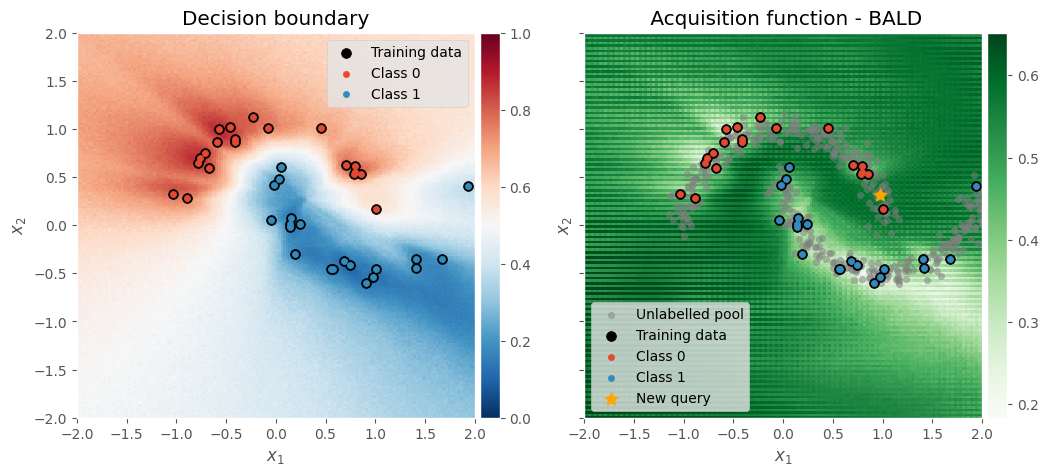

In [14]:
model.predict_proba = model.predict_posterior_proba
with torch.no_grad():
    # Define acquisition function
    acq_fun         = BALD_temp(query_n_points=None, n_posterior_samples=5000)

    # Get acquisition function score and the items to query
    _, query_idxs   = acq_fun(Xpool, model=model)
    next_query      = Xpool[query_idxs[0]]

    # Visualize
    plot_example(acq_fun, next_query)

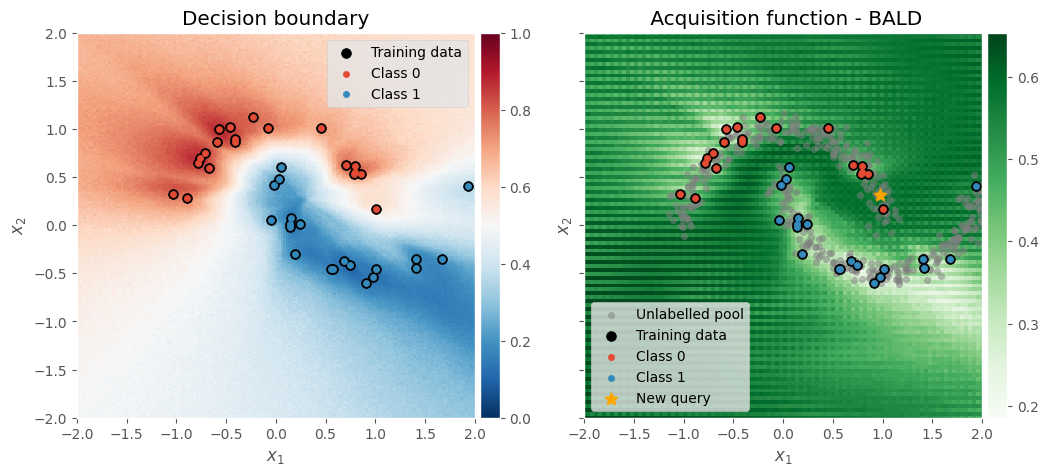

In [11]:
model.predict_proba = model.predict_posterior_proba
with torch.no_grad():
    # Define acquisition function
    acq_fun         = BALD_temp(query_n_points=None, n_posterior_samples=5000)

    # Get acquisition function score and the items to query
    _, query_idxs   = acq_fun(Xpool, model=model)
    next_query      = Xpool[query_idxs[0]]

    # Visualize
    plot_example(acq_fun, next_query)

In [12]:
# model.predict_proba = model.predict_MAP_proba
# with torch.no_grad():
#     # Define acquisition function
#     acq_fun = Entropy(query_n_points=None)

#     # Get acquisition function score and the items to query
#     _, query_idxs = acq_fun(Xpool, model=model)
#     next_query = Xpool[query_idxs[0]]

#     # Visualize
#     plot_example(acq_fun, next_query)

# model.predict_proba = model.predict_posterior_proba
# with torch.no_grad():
#     # Define acquisition function
#     acq_fun = Entropy(query_n_points=None)

#     # Get acquisition function score and the items to query
#     _, query_idxs = acq_fun(Xpool, model=model)
#     next_query = Xpool[query_idxs[0]]

#     # Visualize
#     plot_example(acq_fun, next_query)

# model.predict_proba = model.predict_posterior_proba
# with torch.no_grad():
#     # Define acquisition function
#     acq_fun = BALD(query_n_points=None, n_posterior_samples=1000)

#     # Get acquisition function score and the items to query
#     _, query_idxs = acq_fun(Xpool, model=model)
#     next_query = Xpool[query_idxs[0]]

#     # Visualize
#     plot_example(acq_fun, next_query)

# model.predict_proba = model.predict_posterior_proba
# with torch.no_grad():
#     target_input_dist = MultivariateGaussian(mu=[-1.5, 1.5], Sigma=np.eye(2) / 4)

#     # Define acquisition function
#     acq_fun = EPIG(
#         query_n_points=None, 
#         target_input_distribution=target_input_dist,
#         n_posterior_samples=1000,
#         n_target_input_samples=100,
#         version='mine',
#     )

#     # Get acquisition function score and the items to query
#     _, query_idxs = acq_fun(Xpool, model=model)
#     next_query = Xpool[query_idxs[0]]

#     # Visualize
#     plot_example(acq_fun, next_query)

# model.predict_proba = model.predict_posterior_proba
# with torch.no_grad():
#     target_input_dist = MultivariateGaussian(mu=[1.5, -1.5], Sigma=np.eye(2) / 4)

#     # Define acquisition function
#     acq_fun = EPIG(
#         query_n_points=None, 
#         target_input_distribution=target_input_dist,
#         n_posterior_samples=1000,
#         n_target_input_samples=100,
#         version='mine',
#     )

#     # Get acquisition function score and the items to query
#     _, query_idxs = acq_fun(Xpool, model=model)
#     next_query = Xpool[query_idxs[0]]

#     # Visualize
#     plot_example(acq_fun, next_query)

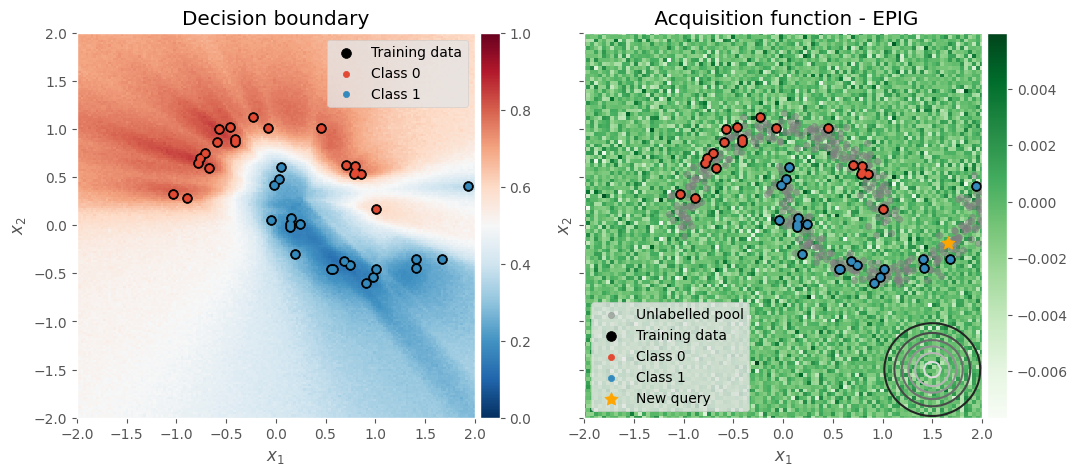

In [42]:
model.predict_proba = model.predict_posterior_proba
with torch.no_grad():
    target_input_dist = MultivariateGaussian(mu=[1.5, -1.5], Sigma=np.eye(2) / 4)

    # Define acquisition function
    acq_fun = GeneralEPIG(
        query_n_points=None, 
        target_input_distribution=target_input_dist,
        n_posterior_samples=5000,
        n_target_input_samples=500,
        version='mine',
    )

    # Get acquisition function score and the items to query
    _, query_idxs = acq_fun(Xpool, model=model)
    next_query = Xpool[query_idxs[0]]


    ### PLOT DECISION BOUNDARY AND ACQUISITION FUNCTION ###
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)

    # Plot model uncertainty across grid
    axs[0] = show_density_grid(model, Xtrain, Xtest, ytrain, ytest, ax=axs[0], fig=fig)
    axs[0].legend()

    # Plot acquisition function across a grid
    axs[1] = show_acquisition_grid(model, acq_fun, Xtrain, ytrain, Xpool, P=100, ax=axs[1], fig=fig)
    axs[1].scatter(next_query[0], next_query[1], color='orange', marker=(5, 1), s=100, label='New query')
    axs[1].legend()

    # Plot target input distribution on top
    target_input_dist.plot_2D(ax=axs[1], zoom=([-2, 3], [-2, 2.5]))

    plt.show()